In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import seaborn as sns
import time

In [219]:
# Try to load the dataset
file_path = 'Groceries_dataset.csv'  # Ensure this is the correct path
try:
    data = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
    print(data.head())  # Show the first few rows to verify
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found. Please check the path.")


Dataset loaded successfully!
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk


In [220]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')


In [221]:
data['Transaction_ID'] = data['Member_number'].astype(str) + "_" + data['Date'].dt.strftime('%Y-%m-%d')


In [222]:
transactions = data.groupby('Transaction_ID')['itemDescription'].apply(list).reset_index()


In [223]:
all_items = sorted(set(item for sublist in transactions['itemDescription'] for item in sublist))


In [224]:
basket_encoded = pd.DataFrame(
    [{item: (item in items) for item in all_items} for items in transactions['itemDescription']]
)

In [225]:
frequent_itemsets_apriori = apriori(basket_encoded, min_support=0.002, use_colnames=True)
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.1, num_itemsets=None)


In [226]:
frequent_itemsets_fpgrowth = fpgrowth(basket_encoded, min_support=0.002, use_colnames=True)
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.1, num_itemsets=None)


In [227]:
frequent_itemsets_apriori.to_csv('frequent_itemsets_apriori.csv', index=False)
rules_apriori.to_csv('rules_apriori.csv', index=False)
frequent_itemsets_fpgrowth.to_csv('frequent_itemsets_fpgrowth.csv', index=False)
rules_fpgrowth.to_csv('rules_fpgrowth.csv', index=False)


In [228]:
print("\nApriori Frequent Itemsets:")
print(frequent_itemsets_apriori.head())
print("\nFP-Growth Frequent Itemsets:")
print(frequent_itemsets_fpgrowth.head())



Apriori Frequent Itemsets:
    support                 itemsets
0  0.004010  (Instant food products)
1  0.021386               (UHT-milk)
2  0.008087          (baking powder)
3  0.033950                   (beef)
4  0.021787                (berries)

FP-Growth Frequent Itemsets:
    support       itemsets
0  0.157923   (whole milk)
1  0.051728       (pastry)
2  0.018780  (salty snack)
3  0.085879       (yogurt)
4  0.060349      (sausage)


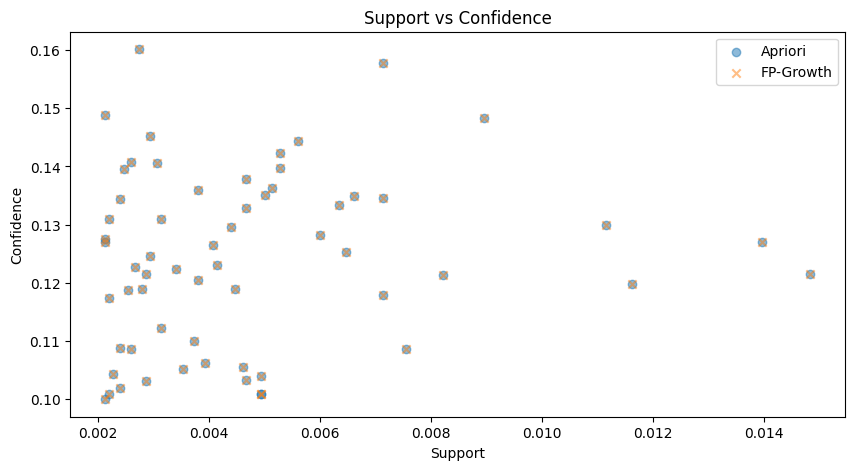

In [229]:
plt.figure(figsize=(10, 5))
plt.scatter(rules_apriori['support'], rules_apriori['confidence'], alpha=0.5, label='Apriori')
plt.scatter(rules_fpgrowth['support'], rules_fpgrowth['confidence'], alpha=0.5, label='FP-Growth', marker='x')
plt.title('Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend()
plt.show()


In [230]:
def predict_transaction_relaxed(new_items, rules):
    predictions = set()
    new_items_set = set(new_items)

    for _, rule in rules.iterrows():
        antecedents = set(rule['antecedents'])
        consequents = set(rule['consequents'])

        # If there's any overlap between antecedents and new_items
        if not antecedents.isdisjoint(new_items_set):
            predictions.update(consequents)

    # Filter predictions to exclude already known items
    predictions = predictions.difference(new_items_set)
    return predictions


In [231]:
new_transaction = ['chocolate', 'other vegetables']

predicted_items_apriori = predict_transaction_relaxed(new_transaction, rules_apriori)
predicted_items_fpgrowth = predict_transaction_relaxed(new_transaction, rules_fpgrowth)

print("Predicted items (Apriori):", predicted_items_apriori)
print("Predicted items (FP-Growth):", predicted_items_fpgrowth)

print("\nApriori Association Rules:")
print(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15))  

print("\nFP-Growth Association Rules:")
print(rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15)) 

Predicted items (Apriori): {'whole milk', 'rolls/buns'}
Predicted items (FP-Growth): {'whole milk', 'rolls/buns'}

Apriori Association Rules:
        antecedents         consequents   support  confidence      lift
0        (UHT-milk)  (other vegetables)  0.002139    0.100000  0.818993
1        (UHT-milk)        (whole milk)  0.002540    0.118750  0.751949
2            (beef)        (whole milk)  0.004678    0.137795  0.872548
3         (berries)  (other vegetables)  0.002673    0.122699  1.004899
4         (berries)        (whole milk)  0.002272    0.104294  0.660414
5    (bottled beer)  (other vegetables)  0.004678    0.103245  0.845568
6    (bottled beer)        (whole milk)  0.007151    0.157817  0.999330
7   (bottled water)        (whole milk)  0.007151    0.117841  0.746196
8     (brown bread)        (whole milk)  0.004478    0.119005  0.753566
9          (butter)        (whole milk)  0.004678    0.132827  0.841090
10          (candy)        (whole milk)  0.002139    0.148837  0.9

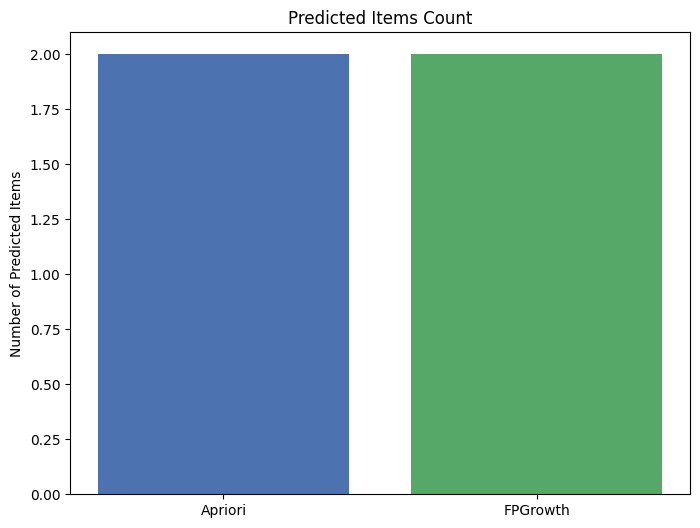

In [232]:
plt.figure(figsize=(8, 6))
labels = ['Apriori', 'FPGrowth']
predictions = [len(predicted_items_apriori), len(predicted_items_fpgrowth)]
plt.bar(labels, predictions, color=['#4C72B0', '#55A868'])
plt.title("Predicted Items Count")
plt.ylabel("Number of Predicted Items")
plt.show()

Execution Time (Apriori): 0.6167 seconds
Execution Time (FP-Growth): 12.0426 seconds
Accuracy (Apriori): 0.50
Accuracy (FP-Growth): 0.50


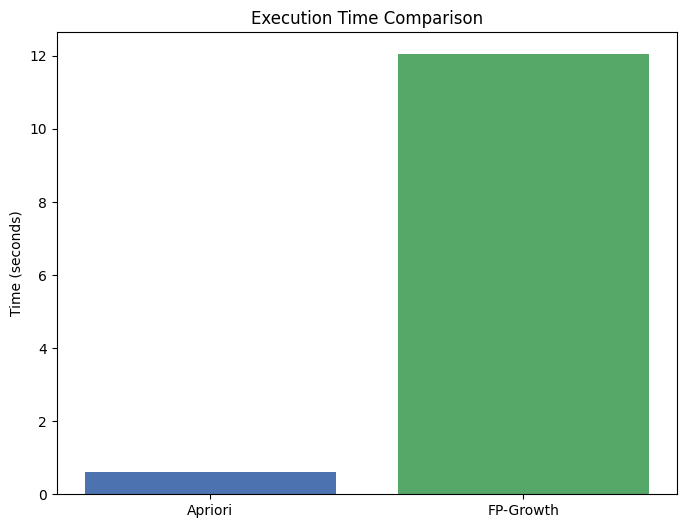

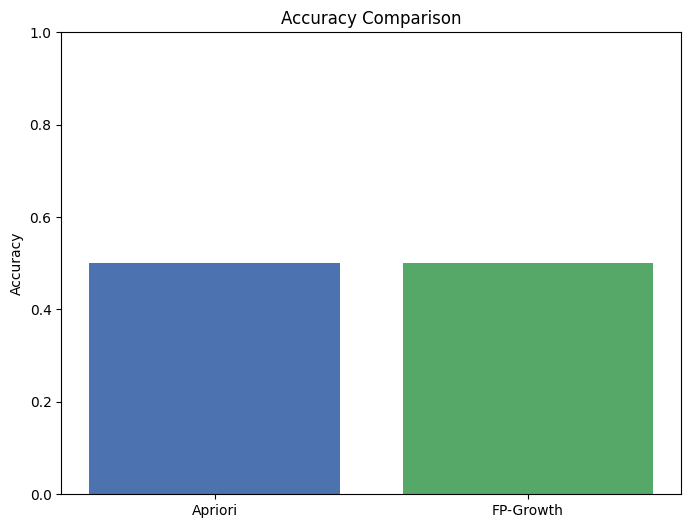

In [233]:
# Adjusting parameters for better accuracy
min_support = 0.002  # Increased minimum support for more relevant itemsets
min_confidence = 0.06 # Increased confidence for stronger association rules

# Start the timer for Apriori with adjusted parameters
start_apriori = time.time()
frequent_itemsets_apriori = apriori(basket_encoded, min_support=min_support, use_colnames=True)
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=min_confidence, num_itemsets=None)
end_apriori = time.time()
time_apriori = end_apriori - start_apriori

# Start the timer for FP-Growth with adjusted parameters
start_fpgrowth = time.time()
frequent_itemsets_fpgrowth = fpgrowth(basket_encoded, min_support=min_support, use_colnames=True)
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=min_confidence, num_itemsets=None)
end_fpgrowth = time.time()
time_fpgrowth = end_fpgrowth - start_fpgrowth

# Define a test transaction and actual items
new_transaction = ['chocolate', 'other vegetables']
actual_items = {'whole milk', 'yogurt'}  # Replace with expected items based on data knowledge

# Predict items using relaxed prediction
predicted_items_apriori = predict_transaction_relaxed(new_transaction, rules_apriori)
predicted_items_fpgrowth = predict_transaction_relaxed(new_transaction, rules_fpgrowth)

# Calculate accuracy for both methods
accuracy_apriori = calculate_accuracy(predicted_items_apriori, actual_items)
accuracy_fpgrowth = calculate_accuracy(predicted_items_fpgrowth, actual_items)

# Print results
print(f"Execution Time (Apriori): {time_apriori:.4f} seconds")
print(f"Execution Time (FP-Growth): {time_fpgrowth:.4f} seconds")
print(f"Accuracy (Apriori): {accuracy_apriori:.2f}")
print(f"Accuracy (FP-Growth): {accuracy_fpgrowth:.2f}")

# Plot execution time comparison
plt.figure(figsize=(8, 6))
plt.bar(['Apriori', 'FP-Growth'], [time_apriori, time_fpgrowth], color=['#4C72B0', '#55A868'])
plt.title("Execution Time Comparison")
plt.ylabel("Time (seconds)")
plt.show()

# Plot accuracy comparison
plt.figure(figsize=(8, 6))
plt.bar(['Apriori', 'FP-Growth'], [accuracy_apriori, accuracy_fpgrowth], color=['#4C72B0', '#55A868'])
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Set y-axis to 0-1 for accuracy
plt.show()
